In [ ]:
# COMPUTING THE VALUES FOR ANALYSIS AND MERGING THE DATASETS

In [ ]:
# Computing avg price as average of open and close price
def avg_price(open_price,close_price):
    return (float(open_price)+float(close_price))/2

# Computing total traded monetary volume(TMV) as volume * avg price
def traded_monetary_volume(volume,open_price,close_price):
    return float(volume)*avg_price(open_price,close_price)

# Computing %price change as 100*(current close price - previous record's close price)/previous record's close price
def percent_price_change(prev_close,curr_close):
    prev_close = float(prev_close)
    curr_close = float(curr_close)
    return 100*(curr_close-prev_close)/prev_close

# Computing %volume change similarly
def percent_tmv_change(prev_tmv,curr_tmv):
    prev_tmv = float(prev_tmv)
    curr_tmv = float(curr_tmv)
    return 100*(curr_tmv-prev_tmv)/prev_tmv

In [103]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df = sqlContext.read.csv('crypto10_final.csv',header=False)
df.show(5)

+---+---+--------+---+-------------------+------------------+------------------+-------------+-----------------+----------------+----+
|_c0|_c1|     _c2|_c3|                _c4|               _c5|               _c6|          _c7|              _c8|             _c9|_c10|
+---+---+--------+---+-------------------+------------------+------------------+-------------+-----------------+----------------+----+
|  0|  1|Polkadot|DOT|2020-08-21 23:59:59|     3.09009266777|2.7309186839899997|2.89692328556|     2.8750282692| 49313136.825242| 0.0|
|  1|  2|Polkadot|DOT|2020-08-22 23:59:59|4.5106133890099995|2.8167618533599996|2.87857004326|4.484690143430001| 485801095.84575| 0.0|
|  2|  3|Polkadot|DOT|2020-08-23 23:59:59|     4.48705836489|3.7162710539199995|4.48705836489|    3.96706569209|320749483.243806| 0.0|
|  3|  4|Polkadot|DOT|2020-08-24 23:59:59|     4.78315823996|3.8126695191300004|3.98741349226|    4.60261415178|407690170.881454| 0.0|
|  4|  5|Polkadot|DOT|2020-08-25 23:59:59| 5.7607753501

In [104]:
# order of columns in original dataframe
# index, sno, name, symbol, date, high, low, open, close, volume, marketcap

# new data with date, symbol, open, close, avg_price and traded monetary volume
# ordered for each currency by date
crypto_data = df.rdd.map(lambda x: (x[4],x[3],x[7],x[8], \
                                    avg_price(x[7],x[8]), \
                                    traded_monetary_volume(x[9],x[7],x[8]), \
                                    )).sortBy(lambda x: (x[1],x[0]) )
df1 = sqlContext.createDataFrame(crypto_data,['date', 'symbol', 'open', 'close', 'avg_price', 'tmv'])
df1.show(5)

In [106]:
# Using window function to find the running difference for price and tmv from the previous record 
from pyspark.sql import functions as F
from pyspark.sql.window import Window
my_window = Window.partitionBy().orderBy('symbol')
df1 = df1.withColumn("prev_symbol", F.lag(df1.symbol).over(my_window))
df1 = df1.withColumn("prev_close", F.lag(df1.close).over(my_window))
df1 = df1.withColumn("prev_tmv", F.lag(df1.tmv).over(my_window))
df1.show(5)

In [108]:
# calculating daily price change
# condition that the previous value be for the same symbol
crypto_index = df1.rdd.map(lambda x: (x[0],x[1], \
                            float(percent_price_change(x[7],x[3]) if not(x[6]!=x[1] or x[7] is None) else percent_price_change(x[2],x[3])), \
                            float(percent_tmv_change(x[8],x[5]) if not(x[6]!=x[1] or  x[8] is None) else 0)))
crypto_index_df = crypto_index.toDF(('date', 'symbol', 'price_change_percent', 'tmv_change_percent'))
crypto_index_df.show(5)

+-------------------+------+--------------------+-------------------+
|               date|symbol|price_change_percent| tmv_change_percent|
+-------------------+------+--------------------+-------------------+
|2018-07-01 23:59:59|   ADA|  2.8525101468518357|                0.0|
|2018-07-02 23:59:59|   ADA|  11.300354998634138|  59.68572995197603|
|2018-07-03 23:59:59|   ADA|  -4.816210574102062|-31.255423960496184|
|2018-07-04 23:59:59|   ADA|  0.2024472898194967| -22.10059289132683|
|2018-07-05 23:59:59|   ADA| -1.3506891984545462|-14.863575086983603|
+-------------------+------+--------------------+-------------------+
only showing top 5 rows



In [112]:
# group by date and find the avg changes in price and volume
crypto_index_final = crypto_index.map(lambda x: (x[0],(x[2],x[3],1)) ) \
            .reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2]) ) \
            .mapValues(lambda y: (y[0]/y[2],y[1]/y[2])) \
            .map(lambda x: (x[0],x[1][0],x[1][1]))
crypto_index_final_df = crypto_index_final.toDF(('date', 'avg_price_change_percent', 'avg_tmv_change_percent'))
crypto_index_final_df.show(5)

+-------------------+------------------------+----------------------+
|               date|avg_price_change_percent|avg_tmv_change_percent|
+-------------------+------------------------+----------------------+
|2018-07-01 23:59:59|     -0.3545608063329723|                   0.0|
|2018-07-02 23:59:59|       5.121125072620959|     9.193665598572519|
|2018-07-03 23:59:59|     -1.7263876931070241|      3.88579704445608|
|2018-07-04 23:59:59|      0.4605982027758544|   -17.906456882074515|
|2018-07-05 23:59:59|     -0.7984669906309387|     5.925269446030441|
+-------------------+------------------------+----------------------+
only showing top 5 rows



In [136]:
# nasdaq100
df = sqlContext.read.csv('nasdaq100_final.csv',header=False)
df.show(5)

# order of columns in original dataframe
# reset_index, index, date, low, open, volume, high, close, adjusted_close

# new data with date, symbol, open, adjusted_close, avg_price and traded monetary volume
# ordered for each stock (already ordered by date)
stock_data = df.rdd.map(lambda x: (x[2],x[9],x[4],x[8], \
                                    avg_price(x[4],x[8]), \
                                    traded_monetary_volume(x[5],x[4],x[8]), \
                                    )).sortBy(lambda x: (x[1]) )
df1 = sqlContext.createDataFrame(stock_data,['date', 'symbol', 'open', 'close', 'avg_price', 'tmv'])
df1.show(5)
# Using window function to find the running difference for price and tmv from the previous record 
my_window = Window.partitionBy().orderBy('symbol')
df1 = df1.withColumn("prev_symbol", F.lag(df1.symbol).over(my_window))
df1 = df1.withColumn("prev_close", F.lag(df1.close).over(my_window))
df1 = df1.withColumn("prev_tmv", F.lag(df1.tmv).over(my_window))
# calculating daily price change
# condition that the previous value be for the same symbol
stock_index = df1.rdd.map(lambda x: (x[0],x[1], \
                            float(percent_price_change(x[7],x[3]) if not(x[6]!=x[1] or x[7] is None) else percent_price_change(x[2],x[3])), \
                            float(percent_tmv_change(x[8],x[5]) if not(x[6]!=x[1] or  x[8] is None) else 0)))
stock_index_df = stock_index.toDF(('date', 'symbol', 'price_change_percent', 'tmv_change_percent'))
stock_index_df.show(5)
# group by date and find the avg changes in price and volume
stock_index_final = stock_index.map(lambda x: (x[0],(x[2],x[3],1)) ) \
            .reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2]) ) \
            .mapValues(lambda y: (y[0]/y[2],y[1]/y[2])) \
            .map(lambda x: (x[0],x[1][0],x[1][1]))
nasdaq100_df = stock_index_final.toDF(('date', 'avg_price_change_percent', 'avg_tmv_change_percent'))
nasdaq100_df.show(5)

+----+----+----------+------------------+------------------+--------+-----------------+------------------+------------------+----+
| _c0| _c1|       _c2|               _c3|               _c4|     _c5|              _c6|               _c7|               _c8| _c9|
+----+----+----------+------------------+------------------+--------+-----------------+------------------+------------------+----+
|7148|7148|02-07-2018| 42.20000076293945|42.560001373291016|21810900|42.83000183105469|42.810001373291016| 38.80120086669922|CSCO|
|7149|7149|03-07-2018| 42.61999893188477| 42.93999862670898|13474700|43.22999954223633| 42.66999816894531|38.674312591552734|CSCO|
|7150|7150|05-07-2018|41.959999084472656|42.560001373291016|18118700|42.63999938964844|42.560001373291016| 38.87525939941406|CSCO|
|7151|7151|06-07-2018|42.310001373291016| 42.38999938964844|20258300|42.88000106811523|42.709999084472656| 39.01226425170898|CSCO|
|7152|7152|09-07-2018| 42.36000061035156|             42.75|23210000|42.77999877929

In [137]:
# sp100
df = sqlContext.read.csv('sp100_final.csv',header=False)
df.show(5)

# order of columns in original dataframe
# reset_index, index, date, low, open, volume, high, close, adjusted_close

# new data with date, symbol, open, adjusted_close, avg_price and traded monetary volume
# ordered for each stock (already ordered by date)
stock_data = df.rdd.map(lambda x: (x[2],x[9],x[4],x[8], \
                                    avg_price(x[4],x[8]), \
                                    traded_monetary_volume(x[5],x[4],x[8]), \
                                    )).sortBy(lambda x: (x[1]) )
df1 = sqlContext.createDataFrame(stock_data,['date', 'symbol', 'open', 'close', 'avg_price', 'tmv'])
df1.show(5)
# Using window function to find the running difference for price and tmv from the previous record 
my_window = Window.partitionBy().orderBy('symbol')
df1 = df1.withColumn("prev_symbol", F.lag(df1.symbol).over(my_window))
df1 = df1.withColumn("prev_close", F.lag(df1.close).over(my_window))
df1 = df1.withColumn("prev_tmv", F.lag(df1.tmv).over(my_window))
# calculating daily price change
# condition that the previous value be for the same symbol
stock_index = df1.rdd.map(lambda x: (x[0],x[1], \
                            float(percent_price_change(x[7],x[3]) if not(x[6]!=x[1] or x[7] is None) else percent_price_change(x[2],x[3])), \
                            float(percent_tmv_change(x[8],x[5]) if not(x[6]!=x[1] or  x[8] is None) else 0)))
stock_index_df = stock_index.toDF(('date', 'symbol', 'price_change_percent', 'tmv_change_percent'))
stock_index_df.show(5)
# group by date and find the avg changes in price and volume
stock_index_final = stock_index.map(lambda x: (x[0],(x[2],x[3],1)) ) \
            .reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2]) ) \
            .mapValues(lambda y: (y[0]/y[2],y[1]/y[2])) \
            .map(lambda x: (x[0],x[1][0],x[1][1]))
sp100_df = stock_index_final.toDF(('date', 'avg_price_change_percent', 'avg_tmv_change_percent'))
sp100_df.show(5)

+----+----+----------+------------------+------------------+--------+-----------------+------------------+------------------+----+
| _c0| _c1|       _c2|               _c3|               _c4|     _c5|              _c6|               _c7|               _c8| _c9|
+----+----+----------+------------------+------------------+--------+-----------------+------------------+------------------+----+
|7148|7148|02-07-2018| 42.20000076293945|42.560001373291016|21810900|42.83000183105469|42.810001373291016| 38.54083633422852|CSCO|
|7149|7149|03-07-2018| 42.61999893188477| 42.93999862670898|13474700|43.22999954223633| 42.66999816894531|38.414798736572266|CSCO|
|7150|7150|05-07-2018|41.959999084472656|42.560001373291016|18118700|42.63999938964844|42.560001373291016|38.614402770996094|CSCO|
|7151|7151|06-07-2018|42.310001373291016| 42.38999938964844|20258300|42.88000106811523|42.709999084472656|    38.75048828125|CSCO|
|7152|7152|09-07-2018| 42.36000061035156|             42.75|23210000|42.77999877929

In [138]:
# nasdaq100Tech
df = sqlContext.read.csv('nasdaq100Tech_final.csv',header=False)
df.show(5)

# order of columns in original dataframe
# reset_index, index, date, low, open, volume, high, close, adjusted_close

# new data with date, symbol, open, adjusted_close, avg_price and traded monetary volume
# ordered for each stock (already ordered by date)
stock_data = df.rdd.map(lambda x: (x[2],x[9],x[4],x[8], \
                                    avg_price(x[4],x[8]), \
                                    traded_monetary_volume(x[5],x[4],x[8]), \
                                    )).sortBy(lambda x: (x[1]) )
df1 = sqlContext.createDataFrame(stock_data,['date', 'symbol', 'open', 'close', 'avg_price', 'tmv'])
df1.show(5)
# Using window function to find the running difference for price and tmv from the previous record 
my_window = Window.partitionBy().orderBy('symbol')
df1 = df1.withColumn("prev_symbol", F.lag(df1.symbol).over(my_window))
df1 = df1.withColumn("prev_close", F.lag(df1.close).over(my_window))
df1 = df1.withColumn("prev_tmv", F.lag(df1.tmv).over(my_window))
# calculating daily price change
# condition that the previous value be for the same symbol
stock_index = df1.rdd.map(lambda x: (x[0],x[1], \
                            float(percent_price_change(x[7],x[3]) if not(x[6]!=x[1] or x[7] is None) else percent_price_change(x[2],x[3])), \
                            float(percent_tmv_change(x[8],x[5]) if not(x[6]!=x[1] or  x[8] is None) else 0)))
stock_index_df = stock_index.toDF(('date', 'symbol', 'price_change_percent', 'tmv_change_percent'))
stock_index_df.show(5)
# group by date and find the avg changes in price and volume
stock_index_final = stock_index.map(lambda x: (x[0],(x[2],x[3],1)) ) \
            .reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2]) ) \
            .mapValues(lambda y: (y[0]/y[2],y[1]/y[2])) \
            .map(lambda x: (x[0],x[1][0],x[1][1]))
nasdaq100Tech_df = stock_index_final.toDF(('date', 'avg_price_change_percent', 'avg_tmv_change_percent'))
nasdaq100Tech_df.show(5)

+----+----+----------+-----------------+------------------+-------+------------------+------------------+-----------------+----+
| _c0| _c1|       _c2|              _c3|               _c4|    _c5|               _c6|               _c7|              _c8| _c9|
+----+----+----------+-----------------+------------------+-------+------------------+------------------+-----------------+----+
|8524|8524|02-07-2018| 95.0500030517578| 95.45999908447266|2029100|  97.1999969482422| 97.05999755859376|92.29022979736328|SWKS|
|8525|8525|03-07-2018| 95.3000030517578|  97.1999969482422|1060600| 97.86000061035156| 95.45999908447266|90.76885223388672|SWKS|
|8526|8526|05-07-2018|             96.5|              96.5|2248500|             99.75| 99.66000366210938|94.76245880126952|SWKS|
|8527|8527|06-07-2018|98.58999633789062| 99.41999816894531|1438400| 100.4499969482422|100.12999725341795| 95.2093505859375|SWKS|
|8528|8528|09-07-2018| 99.2699966430664|100.51000213623048| 994200|100.63999938964844|100.4300003

In [156]:
# reformatting the date column in crypto index to match the style of the stocks index
# 2018-07-01 23:59:59
def reformat_date(date_time_str):
    from datetime import datetime
    date = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    string = date.strftime('%d-%m-%Y')
    return string
    
crypto10 = crypto_index_final_df.rdd.map(lambda x: (reformat_date(x[0]),x[1],x[2]))
crypto10_df = crypto10.toDF(('date', 'avg_price_change_percent', 'avg_tmv_change_percent'))
crypto10_df.show(5)

+----------+------------------------+----------------------+
|      date|avg_price_change_percent|avg_tmv_change_percent|
+----------+------------------------+----------------------+
|01-07-2018|     -0.3545608063329723|                   0.0|
|02-07-2018|       5.121125072620959|     9.193665598572519|
|03-07-2018|     -1.7263876931070241|      3.88579704445608|
|04-07-2018|      0.4605982027758544|   -17.906456882074515|
|05-07-2018|     -0.7984669906309387|     5.925269446030441|
+----------+------------------------+----------------------+
only showing top 5 rows



In [152]:

# checking if we have the same dates across all stock indices
dates = nasdaq100_df.rdd.map(lambda x: x[0]).collect()
a = set(nasdaq100_df.rdd.map(lambda x: x[0]).collect())
b = set(sp100_df.rdd.map(lambda x: x[0]).collect())
c = set(nasdaq100Tech_df.rdd.map(lambda x: x[0]).collect())
print(len(a))
print(a==c and a==b and a==b)
# crypto10 = crypto10_df.rdd.filter(lambda x: x[0] in dates)
# crypto10_df = crypto10.toDF(('date', 'avg_price_change_percent', 'avg_tmv_change_percent'))

756
True


In [154]:
crypto10_df.show(5)

+----------+------------------------+----------------------+
|      date|avg_price_change_percent|avg_tmv_change_percent|
+----------+------------------------+----------------------+
|02-07-2018|       5.121125072620959|     9.193665598572519|
|03-07-2018|     -1.7263876931070241|      3.88579704445608|
|05-07-2018|     -0.7984669906309387|     5.925269446030441|
|06-07-2018|     -0.6435487855691865|    -12.91041562423435|
|09-07-2018|      -1.453540445159325|    -5.414889467143977|
+----------+------------------------+----------------------+
only showing top 5 rows



In [262]:
# Final Data Frames for Analysis
# nasdaq100_df, sp100_df, nasdaq100Tech_df, crypto10_df
crypto10_df.registerTempTable("c")
nasdaq100_df.registerTempTable("n")
sp100_df.registerTempTable("sp")
nasdaq100Tech_df.registerTempTable("nt")

# Joining the datasets on the date column (inner join)
# using sparksql
# weekends and holidays dont have stock market data to relate the crypto currency data with
# selecting only those dates that are also in the stock market data
# leaving out the rest of the dates in the crypto would not be an issue as we are looking into the daily trading trends

# pcp columns denote the daily average price change percentage for each index
# tmvcp columns denote the daily average tmv price chance percentage for each index

data = sqlContext.sql('SELECT C.DATE, C.AVG_PRICE_CHANGE_PERCENT AS C_PCP,  C.AVG_TMV_CHANGE_PERCENT AS C_TMVCP, \
                       N.AVG_PRICE_CHANGE_PERCENT AS N_PCP,  N.AVG_TMV_CHANGE_PERCENT AS N_TMVCP, \
                       SP.AVG_PRICE_CHANGE_PERCENT AS SP_PCP,  SP.AVG_TMV_CHANGE_PERCENT AS SP_TMVCP, \
                       NT.AVG_PRICE_CHANGE_PERCENT AS NT_PCP,  NT.AVG_TMV_CHANGE_PERCENT AS NT_TMVCP \
                       FROM \
                       C INNER JOIN  N ON C.DATE=N.DATE \
                       INNER JOIN SP ON N.DATE=SP.DATE \
                       INNER JOIN NT ON SP.DATE=NT.DATE')
data.show(5)

+----------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+
|      DATE|              C_PCP|            C_TMVCP|             N_PCP|            N_TMVCP|             SP_PCP|           SP_TMVCP|            NT_PCP|           NT_TMVCP|
+----------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+
|05-01-2021|  4.758875395437609|-16.661138694942057| 0.986668583202958|-19.074462545132004| 0.6197781588994877|-17.928091101670976|1.3987598026199135|-19.535695362984107|
|06-04-2020|  8.664879857208723| 59.962016182314336|  8.04945031002814| 50.413138272412056|  6.529639507730578|   43.1436107585446|10.000821349292849|  55.50812866408698|
|22-07-2019|-2.2577123940513006|  2.688357376730594|0.5723747597923099| -9.044564818681529|0.08350758640542237| -15.53638894854748| 1.55433332663

In [263]:
# formatting date to make the conversion easier
def format_date(date_time_str):
    from datetime import datetime
    date = datetime.strptime(date_time_str, '%d-%m-%Y')
    string = date.strftime('%Y-%m-%d')
    return string

datax = data.rdd.sortBy(lambda x: (format_date(x[0])))
data_df = datax.toDF(('DATE', 'C_PCP', 'C_TMVCP', 'N_PCP', 'N_TMVCP', 'SP_PCP', 'SP_TMVCP', 'NT_PCP', 'NT_TMVCP'))
data_df.show(5)

+----------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+
|      DATE|              C_PCP|           C_TMVCP|              N_PCP|           N_TMVCP|              SP_PCP|           SP_TMVCP|             NT_PCP|           NT_TMVCP|
+----------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+
|02-07-2018|  5.121125072620959| 9.193665598572519|-1.4197329157191518|               0.0|   -6.92142945367664|                0.0|-1.3828243249559322|                0.0|
|03-07-2018|-1.7263876931070241|  3.88579704445608|-0.7503701677520215|-34.69465041770667|-0.38754218086889713|-31.618496889332604|-1.4233110883018818| -32.83890509077797|
|05-07-2018|-0.7984669906309387| 5.925269446030441| 1.2241598859767095| 70.59531435527903|  0.9503111182226929|  58.35068850659227|  1.61599

c_pcp


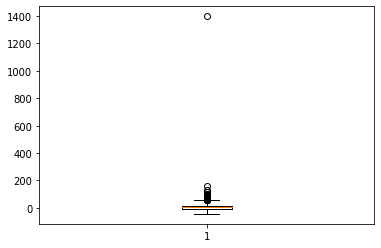

<Figure size 720x504 with 0 Axes>

In [264]:
# Checking for outliers
import matplotlib.pyplot as plt
# c_pcp
plt.boxplot(data_df.rdd.map(lambda x: x[2]).collect())
fig = plt.figure(figsize =(10, 7))
print('c_pcp')
plt.show()

755
c_tmvcp


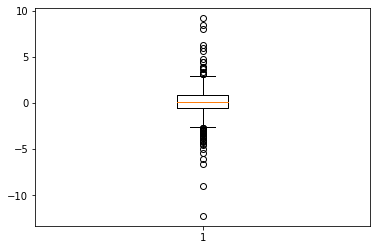

<Figure size 720x504 with 0 Axes>

In [265]:
# let us not remove all the outliers as they could actually represent some really strong days of price movement
# there are a few absurd and very large outliers. One value is above 1300. This has to be removed
data = data_df.rdd.filter(lambda x: x[2]<1300)
print(data.count())
plt.boxplot(data.map(lambda x: x[3]).collect())
fig = plt.figure(figsize = (10, 7))
print('c_tmvcp')
plt.show()

n_pcp


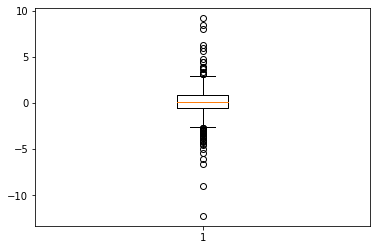

<Figure size 720x504 with 0 Axes>

In [266]:
plt.boxplot(data.map(lambda x: x[3]).collect())
fig = plt.figure(figsize =(10, 7))
print('n_pcp')
plt.show()

n_tmvcp


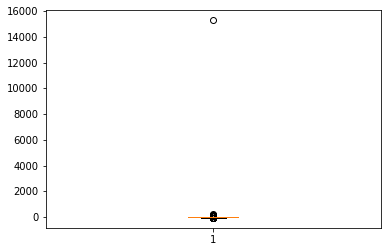

In [267]:
plt.boxplot(data.map(lambda x: x[4]).collect())
print('n_tmvcp')
plt.show()

sp_pcp


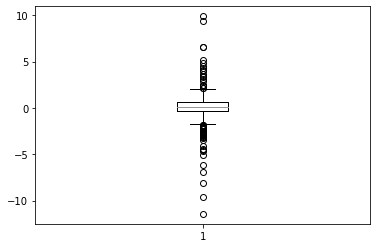

<Figure size 720x504 with 0 Axes>

In [268]:
# there are a few absurd and very large outliers. One value is above 14000. This has to be removed
data = data.filter(lambda x: x[4]<14000)
plt.boxplot(data.map(lambda x: x[5]).collect())
fig = plt.figure(figsize =(10, 7))
print('sp_pcp')
plt.show()

In [273]:
print(data.count())

754


sp_tmvcp


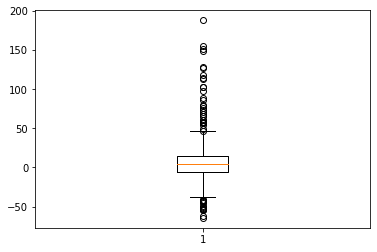

<Figure size 720x504 with 0 Axes>

In [269]:
plt.boxplot(data.map(lambda x: x[6]).collect())
fig = plt.figure(figsize =(10, 7))
print('sp_tmvcp')
plt.show()

nt_pcp


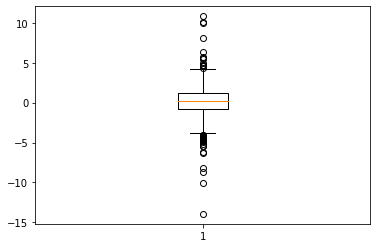

<Figure size 720x504 with 0 Axes>

In [270]:
plt.boxplot(data.map(lambda x: x[7]).collect())
fig = plt.figure(figsize =(10, 7))
print('nt_pcp')
plt.show()

nt_tmvcp


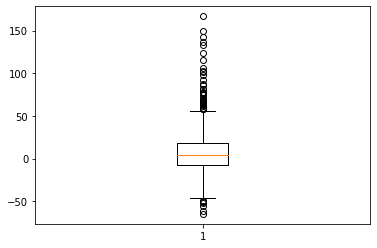

<Figure size 720x504 with 0 Axes>

In [271]:
plt.boxplot(data.map(lambda x: x[8]).collect())
fig = plt.figure(figsize =(10, 7))
print('nt_tmvcp')
plt.show()

In [272]:
# final data with the very large outliers removed, which we will be using for our analysis tasks
data_df = data.toDF(('DATE', 'C_PCP', 'C_TMVCP', 'N_PCP', 'N_TMVCP', 'SP_PCP', 'SP_TMVCP', 'NT_PCP', 'NT_TMVCP'))
data_df.write.csv('data')
!cat data/part* > data.csv

In [ ]:
# Analysis question 1
# How do the overall comparisons of price and volume changes across the markets look like?

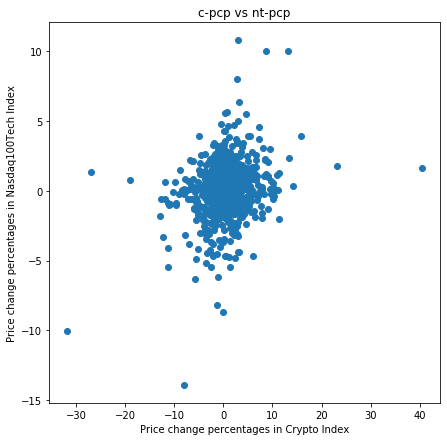

In [194]:
# Scatter plots
import matplotlib.pyplot as plt 
# c-pcp vs n_pcp
cpcp = data.rdd.map(lambda x: x[1]).collect()
npcp = data.rdd.map(lambda x: x[3]).collect()
fig1 = plt.figure(1, figsize=(7, 7))
plt.xlabel('Price change percentages in Crypto Index')
plt.ylabel('Price change percentages in Nasdaq100 Index')
plt.title('c-pcp vs n-pcp')
plt.scatter(cpcp,npcp)
fig1.savefig('Initial_Scatter_Plots_c-pcp vs n-pcp.png', dpi=600) 
# c-pcp vs sp_pcp
plt.clf()
cpcp = data.rdd.map(lambda x: x[1]).collect()
sppcp = data.rdd.map(lambda x: x[5]).collect()
fig2 = plt.figure(1, figsize=(7, 7))
plt.xlabel('Price change percentages in Crypto Index')
plt.ylabel('Price change percentages in S&P100 Index')
plt.title('c-pcp vs sp-pcp')
plt.scatter(cpcp,sppcp)
fig2.savefig('Initial_Scatter_Plots_c-pcp vs sp-pcp.png', dpi=600) 
# c-pcp vs nt_pcp
plt.clf()
cpcp = data.rdd.map(lambda x: x[1]).collect()
ntpcp = data.rdd.map(lambda x: x[7]).collect()
fig3 = plt.figure(1, figsize=(7, 7))
plt.xlabel('Price change percentages in Crypto Index')
plt.ylabel('Price change percentages in Nasdaq100Tech Index')
plt.title('c-pcp vs nt-pcp')
plt.scatter(cpcp,ntpcp)
fig3.savefig('Initial_Scatter_Plots_c-pcp vs nt-pcp.png', dpi=600) 

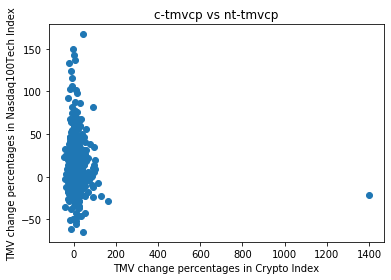

In [195]:
# Scatter plots
# c-tmvcp vs n_tmvcp
plt.clf()
ctmv = data.rdd.map(lambda x: x[2]).collect()
ntmv = data.rdd.map(lambda x: x[4]).collect()
fig1 = plt.figure(1, figsize=(7, 7))
plt.xlabel('TMV change percentages in Crypto Index')
plt.ylabel('TMV change percentages in Nasdaq100 Index')
plt.title('c-tmvcp vs n-tmvcp')
plt.scatter(ctmv,ntmv)
fig1.savefig('Initial_Scatter_Plots_c-tmvcp vs n-tmvcp.png', dpi=600)
# c-tmvcp vs sp_tmvcp
plt.clf()
ctmv = data.rdd.map(lambda x: x[2]).collect()
sptmv = data.rdd.map(lambda x: x[6]).collect()
fig2 = plt.figure(1, figsize=(7, 7))
plt.xlabel('TMV change percentages in Crypto Index')
plt.ylabel('TMV change percentages in S&P100 Index')
plt.title('c-tmvcp vs sp-tmvcp')
plt.scatter(ctmv,sptmv)
fig2.savefig('Initial_Scatter_Plots_c-tmvcp vs sp-tmvcp.png', dpi=600)
# c-tmvcp vs nt_tmvcp
plt.clf()
ctmv = data.rdd.map(lambda x: x[2]).collect()
nttmv = data.rdd.map(lambda x: x[8]).collect()
fig3 = plt.figure(1, figsize=(7, 7))
plt.xlabel('TMV change percentages in Crypto Index')
plt.ylabel('TMV change percentages in Nasdaq100Tech Index')
plt.title('c-tmvcp vs nt-tmvcp')
plt.scatter(ctmv,nttmv)
fig3.savefig('Initial_Scatter_Plots_c-tmvcp vs nt-tmvcp.png', dpi=600)

In [196]:
# In all these plots, the distribution of the change percentages are almost seen to be centered near zero. 
# With both positive and negative changes present for all columns this data.
# There are a few very large outliers when we look at this scatter plot
# This shows that on some days, certain extreme changes have happened. Or it could simply be a data collection error.
# One crypto entry has over 1300% change in tmv
# One Nasdaq100Tech entry has over 14000% change in tmv
# One S&P 
# These could cause a significant difference in the future analyses
# Removing outliers
data_final = data.rdd.filter(lambda x: x[2]<1300 and x[4]<14000 and x[8]<16000)
data_final.count()

754

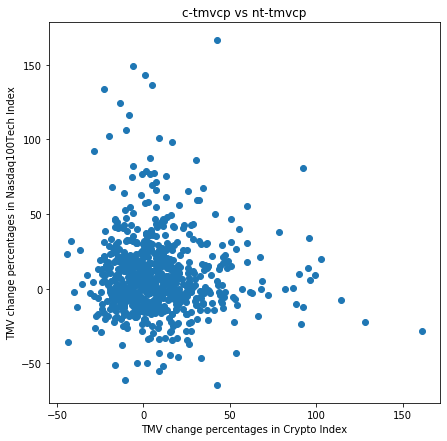

In [200]:
data = data_final
# c-pcp vs n_pcp
cpcp = data.map(lambda x: x[1]).collect()
npcp = data.map(lambda x: x[3]).collect()
fig1 = plt.figure(1, figsize=(7, 7))
plt.xlabel('Price change percentages in Crypto Index')
plt.ylabel('Price change percentages in Nasdaq100 Index')
plt.title('c-pcp vs n-pcp')
plt.scatter(cpcp,npcp)
fig1.savefig('Final_Scatter_Plots_c-pcp vs n-pcp.png', dpi=600) 
# c-pcp vs sp_pcp
plt.clf()
cpcp = data.map(lambda x: x[1]).collect()
sppcp = data.map(lambda x: x[5]).collect()
fig2 = plt.figure(1, figsize=(7, 7))
plt.xlabel('Price change percentages in Crypto Index')
plt.ylabel('Price change percentages in S&P100 Index')
plt.title('c-pcp vs sp-pcp')
plt.scatter(cpcp,sppcp)
fig2.savefig('Final_Scatter_Plots_c-pcp vs sp-pcp.png', dpi=600) 
# c-pcp vs nt_pcp
plt.clf()
cpcp = data.map(lambda x: x[1]).collect()
ntpcp = data.map(lambda x: x[7]).collect()
fig3 = plt.figure(1, figsize=(7, 7))
plt.xlabel('Price change percentages in Crypto Index')
plt.ylabel('Price change percentages in Nasdaq100Tech Index')
plt.title('c-pcp vs nt-pcp')
plt.scatter(cpcp,ntpcp)
fig3.savefig('Final_Scatter_Plots_c-pcp vs nt-pcp.png', dpi=600) 
# c-tmvcp vs n_tmvcp
plt.clf()
ctmv = data.map(lambda x: x[2]).collect()
ntmv = data.map(lambda x: x[4]).collect()
fig1 = plt.figure(1, figsize=(7, 7))
plt.xlabel('TMV change percentages in Crypto Index')
plt.ylabel('TMV change percentages in Nasdaq100 Index')
plt.title('c-tmvcp vs n-tmvcp')
plt.scatter(ctmv,ntmv)
fig1.savefig('Final_Scatter_Plots_c-tmvcp vs n-tmvcp.png', dpi=600)
# c-tmvcp vs sp_tmvcp
plt.clf()
ctmv = data.map(lambda x: x[2]).collect()
sptmv = data.map(lambda x: x[6]).collect()
fig2 = plt.figure(1, figsize=(7, 7))
plt.xlabel('TMV change percentages in Crypto Index')
plt.ylabel('TMV change percentages in S&P100 Index')
plt.title('c-tmvcp vs sp-tmvcp')
plt.scatter(ctmv,sptmv)
fig2.savefig('Final_Scatter_Plots_c-tmvcp vs sp-tmvcp.png', dpi=600)
# c-tmvcp vs nt_tmvcp
plt.clf()
ctmv = data.map(lambda x: x[2]).collect()
nttmv = data.map(lambda x: x[8]).collect()
fig3 = plt.figure(1, figsize=(7, 7))
plt.xlabel('TMV change percentages in Crypto Index')
plt.ylabel('TMV change percentages in Nasdaq100Tech Index')
plt.title('c-tmvcp vs nt-tmvcp')
plt.scatter(ctmv,nttmv)
fig3.savefig('Final_Scatter_Plots_c-tmvcp vs nt-tmvcp.png', dpi=600)

In [209]:
# The final plots, with the outliers removed, reveal 
#     the overall distribution of the changes in crypto index against each stock index considered 
# This is the final data set that we will be using
data_df = data.toDF(('DATE', 'C_PCP', 'C_TMVCP', 'N_PCP', 'N_TMVCP', 'SP_PCP', 'SP_TMVCP', 'NT_PCP', 'NT_TMVCP'))
data_df.write.csv('data')
!cat data/part* > data.csv

In [210]:
# Simple correlation metric
data_df.registerTempTable('data')
# c-pcp vs n_pcp
print('Correlation between daily average price change percentages between the crypto index and nasdaq100')
cor1 = sqlContext.sql('SELECT ((AVG(C_PCP * N_PCP) - (AVG(C_PCP) * AVG(N_PCP))) / (STDDEV(C_PCP) * STDDEV(N_PCP))) AS CORRELATION FROM DATA ')
cor1.show()
# c-pcp vs sp_pcp
print('Correlation between daily average price change percentages between the crypto index and sp100')
cor1 = sqlContext.sql('SELECT ((AVG(C_PCP * SP_PCP) - (AVG(C_PCP) * AVG(SP_PCP))) / (STDDEV(C_PCP) * STDDEV(SP_PCP))) AS CORRELATION FROM DATA ')
cor1.show()
# c-pcp vs nt_pcp
print('Correlation between daily average price change percentages between the crypto index and nasdaqTech100')
cor1 = sqlContext.sql('SELECT ((AVG(C_PCP * NT_PCP) - (AVG(C_PCP) * AVG(NT_PCP))) / (STDDEV(C_PCP) * STDDEV(NT_PCP))) AS CORRELATION FROM DATA ')
cor1.show()

Correlation between daily average price change percentages between the crypto index and nasdaq100
+------------------+
|       CORRELATION|
+------------------+
|0.2554647488693455|
+------------------+

Correlation between daily average price change percentages between the crypto index and sp100
+-------------------+
|        CORRELATION|
+-------------------+
|0.22803170694955108|
+-------------------+

Correlation between daily average price change percentages between the crypto index and nasdaqTech100
+------------------+
|       CORRELATION|
+------------------+
|0.2539864462151664|
+------------------+



In [ ]:
# COMMENT

In [211]:
# Simple correlation metric
# c-tmvcp vs n_tmvcp
print('Correlation between daily average traded monetary volume change percentages between the crypto index and nasdaq100')
cor1 = sqlContext.sql('SELECT ((AVG(C_TMVCP * N_TMVCP) - (AVG(C_TMVCP) * AVG(N_TMVCP))) / (STDDEV(C_TMVCP) * STDDEV(N_TMVCP))) AS CORRELATION FROM DATA ')
cor1.show()
# c-tmvcp vs sp_tmvcp
print('Correlation between daily average traded monetary volume change percentages between the crypto index and sp100')
cor1 = sqlContext.sql('SELECT ((AVG(C_TMVCP * SP_TMVCP) - (AVG(C_TMVCP) * AVG(SP_TMVCP))) / (STDDEV(C_TMVCP) * STDDEV(SP_TMVCP))) AS CORRELATION FROM DATA ')
cor1.show()
# c-tmvcp vs nt_tmvcp
print('Correlation between daily average traded monetary volume change percentages between the crypto index and nasdaqTech100')
cor1 = sqlContext.sql('SELECT ((AVG(C_TMVCP * NT_TMVCP) - (AVG(C_TMVCP) * AVG(NT_TMVCP))) / (STDDEV(C_TMVCP) * STDDEV(NT_TMVCP))) AS CORRELATION FROM DATA ')
cor1.show()

Correlation between daily average traded monetary volume change percentages between the crypto index and nasdaq100
+--------------------+
|         CORRELATION|
+--------------------+
|-0.00409274641338...|
+--------------------+

Correlation between daily average traded monetary volume change percentages between the crypto index and sp100
+-------------------+
|        CORRELATION|
+-------------------+
|0.02074769155349306|
+-------------------+

Correlation between daily average traded monetary volume change percentages between the crypto index and nasdaqTech100
+--------------------+
|         CORRELATION|
+--------------------+
|-0.02779351180686479|
+--------------------+



In [ ]:
# COMMENT

In [ ]:
# ANALYSIS TASK 2
# How similar are the directional nature of the swings in the price and volume in the markets?

In [231]:
# Columns
# 'DATE', 'C_PCP', 'C_TMVCP', 'N_PCP', 'N_TMVCP', 'SP_PCP', 'SP_TMVCP', 'NT_PCP', 'NT_TMVCP'
print('Comparing daily avg price change percentage across the indices')
print('Crypto vs Nasdaq100')
pp = data_df.rdd.filter(lambda x: (x[1]>0 and x[3]>0) or (x[1]==0 and x[3]==0)).count()
nn = data_df.rdd.filter(lambda x: (x[1]<0 and x[3]<0)).count()
pn = data_df.rdd.filter(lambda x: (x[1]>0 and x[3]<0)).count()
np = data_df.rdd.filter(lambda x: (x[1]<0 and x[3]>0)).count()
import pandas as pd
data = [[pp,pn],[np,nn]]
columns = ['nasdaq100_positive','nasdaq100_negative']
indices = ['crypto_positive','crypto_negative']
df = pd.DataFrame(data,indices,columns)
print(df)
print('Percentage of records having the same direction of price change: ' + str(100*(pp+nn)/(pp+pn+np+nn)))

Comparing daily avg price change percentage across the indices
Crypto vs Nasdaq100
                 nasdaq100_positive  nasdaq100_negative
crypto_positive                 252                 153
crypto_negative                 170                 179
Percentage of records having the same direction of price change: 57.16180371352785


In [232]:
print('Crypto vs S&P100')
pp = data_df.rdd.filter(lambda x: (x[1]>0 and x[5]>0) or (x[1]==0 and x[5]==0)).count()
nn = data_df.rdd.filter(lambda x: (x[1]<0 and x[5]<0)).count()
pn = data_df.rdd.filter(lambda x: (x[1]>0 and x[5]<0)).count()
np = data_df.rdd.filter(lambda x: (x[1]<0 and x[5]>0)).count()
import pandas as pd
data = [[pp,pn],[np,nn]]
columns = ['s&p100_positive','s&p100_negative']
indices = ['crypto_positive','crypto_negative']
df = pd.DataFrame(data,indices,columns)
print(df)
print('Percentage of records having the same direction of price change: ' + str(100*(pp+nn)/(pp+pn+np+nn)))

Crypto vs S&P100
                 s&p100_positive  s&p100_negative
crypto_positive              242              163
crypto_negative              180              169
Percentage of records having the same direction of price change: 54.50928381962865


In [233]:
print('Crypto vs Nasdaq100Tech')
pp = data_df.rdd.filter(lambda x: (x[1]>0 and x[7]>0) or (x[1]==0 and x[7]==0)).count()
nn = data_df.rdd.filter(lambda x: (x[1]<0 and x[7]<0)).count()
pn = data_df.rdd.filter(lambda x: (x[1]>0 and x[7]<0)).count()
np = data_df.rdd.filter(lambda x: (x[1]<0 and x[7]>0)).count()
import pandas as pd
data = [[pp,pn],[np,nn]]
columns = ['nasdaq100Tech_positive','nasdaq100Tech_negative']
indices = ['crypto_positive','crypto_negative']
df = pd.DataFrame(data,indices,columns)
print(df)
print('Percentage of records having the same direction of price change: ' + str(100*(pp+nn)/(pp+pn+np+nn)))

Crypto vs Nasdaq100Tech
                 nasdaq100Tech_positive  nasdaq100Tech_negative
crypto_positive                     250                     155
crypto_negative                     175                     174
Percentage of records having the same direction of price change: 56.23342175066313


In [234]:
print('Comparing daily avg traded monetary volume change percentage across the indices')
print('Crypto vs Nasdaq100')
pp = data_df.rdd.filter(lambda x: (x[2]>0 and x[4]>0) or (x[2]==0 and x[4]==0)).count()
nn = data_df.rdd.filter(lambda x: (x[2]<0 and x[4]<0)).count()
pn = data_df.rdd.filter(lambda x: (x[2]>0 and x[4]<0)).count()
np = data_df.rdd.filter(lambda x: (x[2]<0 and x[4]>0)).count()
import pandas as pd
data = [[pp,pn],[np,nn]]
columns = ['nasdaq100_positive','nasdaq100_negative']
indices = ['crypto_positive','crypto_negative']
df = pd.DataFrame(data,indices,columns)
print(df)
print('Percentage of records having the same direction of tmv change: ' + str(100*(pp+nn)/(pp+pn+np+nn)))

Comparing daily avg traded monetary volume change percentage across the indices
Crypto vs Nasdaq100
                 nasdaq100_positive  nasdaq100_negative
crypto_positive                 283                 146
crypto_negative                 203                 121
Percentage of records having the same direction of tmv change: 53.65205843293493


In [235]:
print('Crypto vs S&P100')
pp = data_df.rdd.filter(lambda x: (x[2]>0 and x[6]>0) or (x[2]==0 and x[6]==0)).count()
nn = data_df.rdd.filter(lambda x: (x[2]<0 and x[6]<0)).count()
pn = data_df.rdd.filter(lambda x: (x[2]>0 and x[6]<0)).count()
np = data_df.rdd.filter(lambda x: (x[2]<0 and x[6]>0)).count()
import pandas as pd
data = [[pp,pn],[np,nn]]
columns = ['s&p100_positive','s&p100_negative']
indices = ['crypto_positive','crypto_negative']
df = pd.DataFrame(data,indices,columns)
print(df)
print('Percentage of records having the same direction of tmv change: ' + str(100*(pp+nn)/(pp+pn+np+nn)))

Crypto vs S&P100
                 s&p100_positive  s&p100_negative
crypto_positive              273              156
crypto_negative              180              144
Percentage of records having the same direction of tmv change: 55.37848605577689


In [236]:
print('Crypto vs Nasdaq100Tech')
pp = data_df.rdd.filter(lambda x: (x[2]>0 and x[8]>0) or (x[2]==0 and x[8]==0)).count()
nn = data_df.rdd.filter(lambda x: (x[2]<0 and x[8]<0)).count()
pn = data_df.rdd.filter(lambda x: (x[2]>0 and x[8]<0)).count()
np = data_df.rdd.filter(lambda x: (x[2]<0 and x[8]>0)).count()
import pandas as pd
data = [[pp,pn],[np,nn]]
columns = ['nasdaq100Tech_positive','nasdaq100Tech_negative']
indices = ['crypto_positive','crypto_negative']
df = pd.DataFrame(data,indices,columns)
print(df)
print('Percentage of records having the same direction of tmv change: ' + str(100*(pp+nn)/(pp+pn+np+nn)))

Crypto vs Nasdaq100Tech
                 nasdaq100Tech_positive  nasdaq100Tech_negative
crypto_positive                     242                     187
crypto_negative                     183                     141
Percentage of records having the same direction of tmv change: 50.863213811420984


In [ ]:
# COMMENT

In [ ]:
# ANALYSIS TASK 3
# How do the stock trends affect the crypto trends?

In [242]:
# cross correlation - time lagged
# price change percent
# crypto and nasdaq100

data1 = data_df.rdd.map(lambda x: (x[0],x[1],x[3]))
data1_df = data1.toDF(('DATE','C_PCP','N_PCP'))


In [244]:
data_df.show(5)

+----------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+
|      DATE|              C_PCP|            C_TMVCP|             N_PCP|            N_TMVCP|             SP_PCP|           SP_TMVCP|            NT_PCP|           NT_TMVCP|
+----------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+
|05-01-2021|  4.758875395437609|-16.661138694942057| 0.986668583202958|-19.074462545132004| 0.6197781588994877|-17.928091101670976|1.3987598026199135|-19.535695362984107|
|06-04-2020|  8.664879857208723| 59.962016182314336|  8.04945031002814| 50.413138272412056|  6.529639507730578|   43.1436107585446|10.000821349292849|  55.50812866408698|
|22-07-2019|-2.2577123940513006|  2.688357376730594|0.5723747597923099| -9.044564818681529|0.08350758640542237| -15.53638894854748| 1.55433332663